# Arabic NLP Project – KALIMAT Dataset

## Table of Contents

1. [Introduction](#1-introduction)
2. [Data Exploration and Preprocessing](#2-data-exploration-and-preprocessing)
3. [Phase 1: Traditional Approaches](#3-phase-1-traditional-approaches)

## 1. Introduction

### Project overview and objectives

This project explores two core NLP tasks on Arabic text data: text classification and text summarization. The goal is to evaluate and compare traditional machine learning methods and modern deep learning/transformer-based models in the context of Arabic language processing. The project aims to highlight how each approach handles Arabic-specific linguistic challenges and determine the most effective techniques for each task.

### Description of the chosen dataset and tasks

Two different datasets are used in this project, one for each task:

1. **KALIMAT Corpus** used for **Task 1: Text Classification**. It contains Arabic texts categorized into six topics: culture, economy, local news, international news, religion, and sports.

2. **Summarization Corpus** used for **Task 2: Text Summarization**. It includes Arabic texts paired with corresponding summaries.

The two NLP tasks implemented are:

**Task 1 Text Classification**: assigning topic labels to Arabic texts.

**Task 2 Text Summarization**: producing concise summaries from Arabic texts and comparing extractive and generative approaches.

### Brief background on relevant challenges (Arabic NLP or multimodal processing)

Arabic NLP is challenging due to the language’s rich morphology, root-based word structure, and multiple forms of the same letter. A major issue is that diacritics (harakat), which are important for meaning, are often omitted in writing, leading to ambiguity. Tokenization, stemming, and normalization are more difficult than in English. There's also limited availability of large annotated datasets, and differences between Modern Standard Arabic and dialects make generalization harder. Preprocessing is important, but small mistakes in normalization or stemming can change word meanings and affect results.

In [ ]:
!pip install git+https://github.com/ARBML/rouge_score_ar
!pip install rouge_score

  Cloning https://github.com/ARBML/rouge_score_ar to /tmp/pip-req-build-h02p9nc2
  Running command git clone --filter=blob:none --quiet https://github.com/ARBML/rouge_score_ar /tmp/pip-req-build-h02p9nc2
  Resolved https://github.com/ARBML/rouge_score_ar to commit 74e50809e2c52b034ccdc6825fb2bff113bcbdfe
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score_ar: filename=rouge_score_ar-0.1.2-py3-none-any.whl size=19176 sha256=d6e0322b47223540f6eea11eeef170287b85417c8e4097cbff60fddd3c8ae12f
  Stored in directory: /tmp/pip-ephem-wheel-cache-7uowi0ta/wheels/d3/f4/57/b79d000eafab023f843bbd4cbaf60d239e2db14d63aba9e1e3
Successfully built rouge_score_ar
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=61f8c12e327d6adf0cb09439c3ecd6562cbf01703447c299bdf65db8443ee077
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built 

In [ ]:
# Standard library imports
import glob
import os
import joblib
import re
from IPython.display import Markdown, display

# Data handling and visualization
import gdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from rouge_score import rouge_scorer

# Scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_fscore_support,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC

# Deep learning libraries
import torch

# Transformers
from transformers import (
    set_seed,
)


# Download NLTK data
nltk.download("stopwords", quiet=True)

True

## Global Configuration & Constants

In [ ]:
# Global Configuration
RANDOM_SEED = 0
TEST_SIZE = 0.2

# Model hyperparameters - Classification
CLASSIFICATION_MAX_LENGTH = 512
CLASSIFICATION_BATCH_SIZE = 32
CLASSIFICATION_EPOCHS = 15
CLASSIFICATION_LEARNING_RATE = 0.001

# Model hyperparameters - LSTM
LSTM_MAX_WORDS = 10000
LSTM_EMBEDDING_DIM = 100
LSTM_HIDDEN_DIM = 128
LSTM_N_LAYERS = 2
LSTM_DROPOUT = 0.5

# Model hyperparameters - BERT
BERT_MODEL_NAME = "aubmindlab/bert-base-arabertv02"
BERT_MAX_LENGTH = 256
BERT_BATCH_SIZE = 16
BERT_EPOCHS = 3
BERT_LEARNING_RATE = 2e-5

# Model hyperparameters - Summarization
SUM_MAX_TEXT_LENGTH = 200
SUM_MAX_SUMMARY_LENGTH = 40
SUM_VOCAB_SIZE = 10000
SUM_BATCH_SIZE = 32
SUM_EPOCHS = 10
SUM_LEARNING_RATE = 0.001

# Seq2Seq model parameters
SEQ2SEQ_EMBED_DIM = 128
SEQ2SEQ_HIDDEN_DIM = 512
SEQ2SEQ_N_LAYERS = 1
SEQ2SEQ_DROPOUT = 0.3
SEQ2SEQ_TEACHER_FORCING_RATIO = 0.5

# Sequence length parameters
MAX_TEXT_LEN = 500
MAX_SUM_LEN = 50
BATCH_SIZE = 32

set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name()}")
    torch.backends.cudnn.benchmark = True
    torch.cuda.manual_seed_all(RANDOM_SEED)

# Model save paths
MODEL_SAVE_DIR = "./saved_models/"
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

Using device: cuda
CUDA device: Tesla T4


In [ ]:
def print_text_sample(text, title="Text Sample"):
    print(f"\n{title}:")
    print("=" * len(title))
    display(Markdown(str(text)))
    print(f"\n[Full length: {len(str(text)):,} characters]\n")


def save_model(model, path, metadata=None):
    save_dict = {"model_state_dict": model.state_dict(), "metadata": metadata or {}}
    torch.save(save_dict, path)


def load_model(model, path):
    if os.path.exists(path):
        checkpoint = torch.load(path, map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])
        return checkpoint.get("metadata", {})
    return {}


def display_model_comparison(models_results, metric_name="Accuracy"):
    print(f"\n{'=' * 50}")
    print(f"MODEL COMPARISON - {metric_name.upper()}")
    print(f"{'=' * 50}")

    for model_name, result in models_results.items():
        print(f"{model_name:<25}: {result:.4f}")

    best_model = max(models_results.items(), key=lambda x: x[1])
    print(f"\nBest performing model: {best_model[0]} ({best_model[1]:.4f})")
    print(f"{'=' * 50}\n")

## 2. Data Exploration and Preprocessing

### Dataset Loading and Exploration

In [ ]:
# Google Drive file IDs for datasets
kalimat_id = "1ews4QEXGC9bW5eKumlqTKgLEC06Cqbtw"
summarization_id = "1V7kFgZdlHeTucA9eowNBNy9TG08VDxcY"

print("Downloading datasets...")
gdown.download(
    f"https://drive.google.com/uc?id={kalimat_id}", "kalimat_corpus.zip", quiet=False
)
gdown.download(
    f"https://drive.google.com/uc?id={summarization_id}",
    "summarization_corpus.csv",
    quiet=False,
)

!unzip -q kalimat_corpus.zip -d ./kalimat_corpus
!rm kalimat_corpus.zip

Downloading...
From (original): https://drive.google.com/uc?id=1ews4QEXGC9bW5eKumlqTKgLEC06Cqbtw
From (redirected): https://drive.google.com/uc?id=1ews4QEXGC9bW5eKumlqTKgLEC06Cqbtw&confirm=t&uuid=6baa5dc8-5ec9-43b4-a99c-5a629bf1da1a
To: /content/kalimat_corpus.zip
100%|██████████| 34.9M/34.9M [00:00<00:00, 38.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1V7kFgZdlHeTucA9eowNBNy9TG08VDxcY
To: /content/summarization_corpus.csv
100%|██████████| 37.9M/37.9M [00:01<00:00, 34.2MB/s]


In [ ]:
classification_corpus_path = "./kalimat_corpus"
classification_topic_map = {
    "articlesCulture": "culture",
    "articlesEconomy": "economy",
    "articlesLocal": "local",
    "articlesInternational": "international",
    "articlesReligion": "religion",
    "articlesSports": "sports",
}

classification_data = []

for folder, label in tqdm(classification_topic_map.items(), desc="Processing folders"):
    folder_path = os.path.join(classification_corpus_path, folder)
    file_paths = glob.glob(os.path.join(folder_path, "*"))

    for file_path in tqdm(file_paths, desc=f"Loading {label}", leave=False):
        try:
            with open(file_path, "r", encoding="utf-8") as f:
                text = f.read().strip()
                if text:
                    classification_data.append((text, label))
        except Exception:
            continue

classification_df = pd.DataFrame(classification_data, columns=["text", "label"])

summarization_corpus_path = "./summarization_corpus.csv"
summarization_df = pd.read_excel(summarization_corpus_path, header=1)

print(f"Classification samples: {len(classification_df):,}")
print(f"Summarization samples: {len(summarization_df):,}")

Processing folders: 100%|██████████| 6/6 [00:02<00:00,  2.59it/s]


Classification samples: 18,256
Summarization samples: 29,335


#### Kalimat Corpus

In [ ]:
print(f"Classification - Total: {len(classification_df)}")
print(f"Classification - Unique: {classification_df['text'].nunique()}")
print(f"Classification - Duplicates: {classification_df['text'].duplicated().sum()}")
print(f"Classification - Missing: {classification_df.isnull().sum().sum()}")

Classification - Total: 18256
Classification - Unique: 15221
Classification - Duplicates: 3035
Classification - Missing: 0


In [ ]:
print("\nClass Distribution:")
print(classification_df["label"].value_counts())


Class Distribution:
label
sports           4095
religion         3475
economy          3265
local            3237
culture          2495
international    1689
Name: count, dtype: int64


#### Summarization Corpus

In [ ]:
print(f"\nSummarization - Total: {len(summarization_df)}")
print(f"Summarization - Unique: {summarization_df['text'].nunique()}")
print(f"Summarization - Duplicates: {summarization_df['text'].duplicated().sum()}")
print(f"Summarization - Missing: {summarization_df.isnull().sum().sum()}")


Summarization - Total: 29335
Summarization - Unique: 29192
Summarization - Duplicates: 142
Summarization - Missing: 189


### Preprocessing

Arabic text preprocessing is crucial for model performance. Unlike English, Arabic requires handling of:
- **Diacritics removal**: Harakat marks that are often inconsistent in modern texts
- **Character normalization**: Multiple forms of the same letter (أ, إ, آ → ا)
- **Root-based stemming**: Extracting word roots while preserving meaning

The preprocessing pipeline balances normalization with information preservation, as aggressive preprocessing can lose important semantic distinctions in Arabic.

In [ ]:
# Initialize Arabic NLP tools
arabic_stopwords = set(stopwords.words("arabic"))
stemmer = ISRIStemmer()

# Character normalization mapping
char_map = str.maketrans(
    {"أ": "ا", "إ": "ا", "آ": "ا", "ى": "ي", "ة": "ه", "ؤ": "و", "ئ": "ي", "ـ": ""}
)

# Compiled regex patterns
diacritics_pattern = re.compile(r"[\u064B-\u0652]")
punctuation_pattern = re.compile(r"[^\w\s]")
whitespace_pattern = re.compile(r"\s+")
repeated_char_pattern = re.compile(r"(.)\1+")
digits_pattern = re.compile(r"\d+")


def normalize_arabic(text):
    return text.translate(char_map)


def remove_diacritics(text):
    return diacritics_pattern.sub("", text)


def remove_punctuation(text):
    return punctuation_pattern.sub(" ", text)


def reduce_repeated_characters(text):
    return repeated_char_pattern.sub(r"\1", text)


def remove_stopwords(tokens):
    return [word for word in tokens if word not in arabic_stopwords]


def stem_tokens(tokens):
    return [stemmer.stem(token) for token in tokens]


def preprocess_for_classification(text):
    if not isinstance(text, str):
        return ""

    text = text.strip().lower()
    text = normalize_arabic(text)
    text = remove_diacritics(text)
    text = remove_punctuation(text)
    text = reduce_repeated_characters(text)
    text = whitespace_pattern.sub(" ", text).strip()
    text = digits_pattern.sub("", text)

    tokens = text.split()
    tokens = remove_stopwords(tokens)
    tokens = stem_tokens(tokens)

    return " ".join(tokens)


def preprocess_for_summarization(text):
    if not isinstance(text, str):
        return ""

    text = text.strip().lower()
    text = remove_diacritics(text)
    text = whitespace_pattern.sub(" ", text).strip()
    text = digits_pattern.sub("", text)

    return text

In [ ]:
print("Preprocessing classification data...")

# Remove duplicates
original_count = len(classification_df)
classification_df = classification_df.drop_duplicates(
    subset=["text"], keep="first"
).reset_index(drop=True)

# Apply preprocessing
tqdm.pandas(desc="Preprocessing texts")
classification_df["preprocessed_text"] = classification_df["text"].progress_apply(
    preprocess_for_classification
)

# Remove empty preprocessed texts
classification_df = classification_df[
    classification_df["preprocessed_text"].str.len() > 0
].reset_index(drop=True)

print(f"Removed {original_count - len(classification_df):,} duplicates/empty entries")
print(f"Final classification samples: {len(classification_df):,}")

Preprocessing classification data...


Preprocessing texts: 100%|██████████| 15221/15221 [00:50<00:00, 299.46it/s]

Removed 3,035 duplicates/empty entries
Final classification samples: 15,221


In [ ]:
print("Preprocessing summarization data...")

original_count = len(summarization_df)
summarization_df = summarization_df.drop_duplicates(
    subset=["text"], keep="first"
).reset_index(drop=True)
summarization_df = summarization_df.dropna(subset=["text", "summary"]).reset_index(
    drop=True
)

summarization_df["text_length"] = summarization_df["text"].str.len()
summarization_df["summary_length"] = summarization_df["summary"].str.len()

print(f"Cleaned {original_count - len(summarization_df):,} entries")
print(f"Final summarization samples: {len(summarization_df):,}")
print(f"Average text length: {summarization_df['text_length'].mean():.0f} characters")
print(
    f"Average summary length: {summarization_df['summary_length'].mean():.0f} characters"
)

Preprocessing summarization data...
Cleaned 143 entries
Final summarization samples: 29,192
Average text length: 1966 characters
Average summary length: 178 characters


### Data Visualization and Statistics

#### Kalimat Corpus

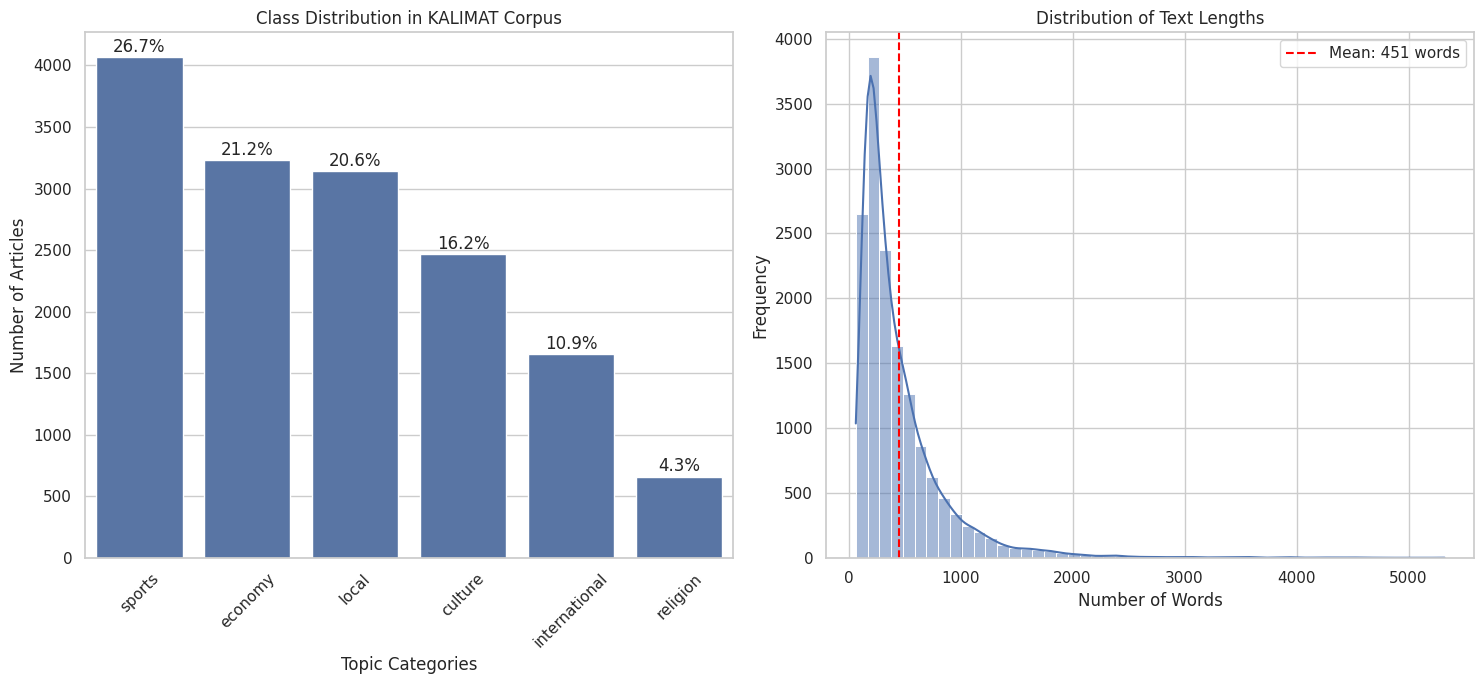

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Class distribution
sns.countplot(
    data=classification_df,
    x="label",
    order=classification_df["label"].value_counts().index,
    ax=ax1,
)
ax1.set_title("Class Distribution in KALIMAT Corpus")
ax1.set_xlabel("Topic Categories")
ax1.set_ylabel("Number of Articles")
ax1.tick_params(axis="x", rotation=45)

total = len(classification_df)
for i, (label, count) in enumerate(classification_df["label"].value_counts().items()):
    percentage = (count / total) * 100
    ax1.text(i, count + 10, f"{percentage:.1f}%", ha="center", va="bottom")


# Text length distribution
text_lengths = classification_df["text"].apply(lambda x: len(x.split()))
sns.histplot(text_lengths, bins=50, kde=True, ax=ax2)
ax2.set_title("Distribution of Text Lengths")
ax2.set_xlabel("Number of Words")
ax2.set_ylabel("Frequency")
ax2.axvline(
    text_lengths.mean(),
    color="red",
    linestyle="--",
    label=f"Mean: {text_lengths.mean():.0f} words",
)
ax2.legend()

plt.tight_layout()
plt.show()

#### Summarization Corpus

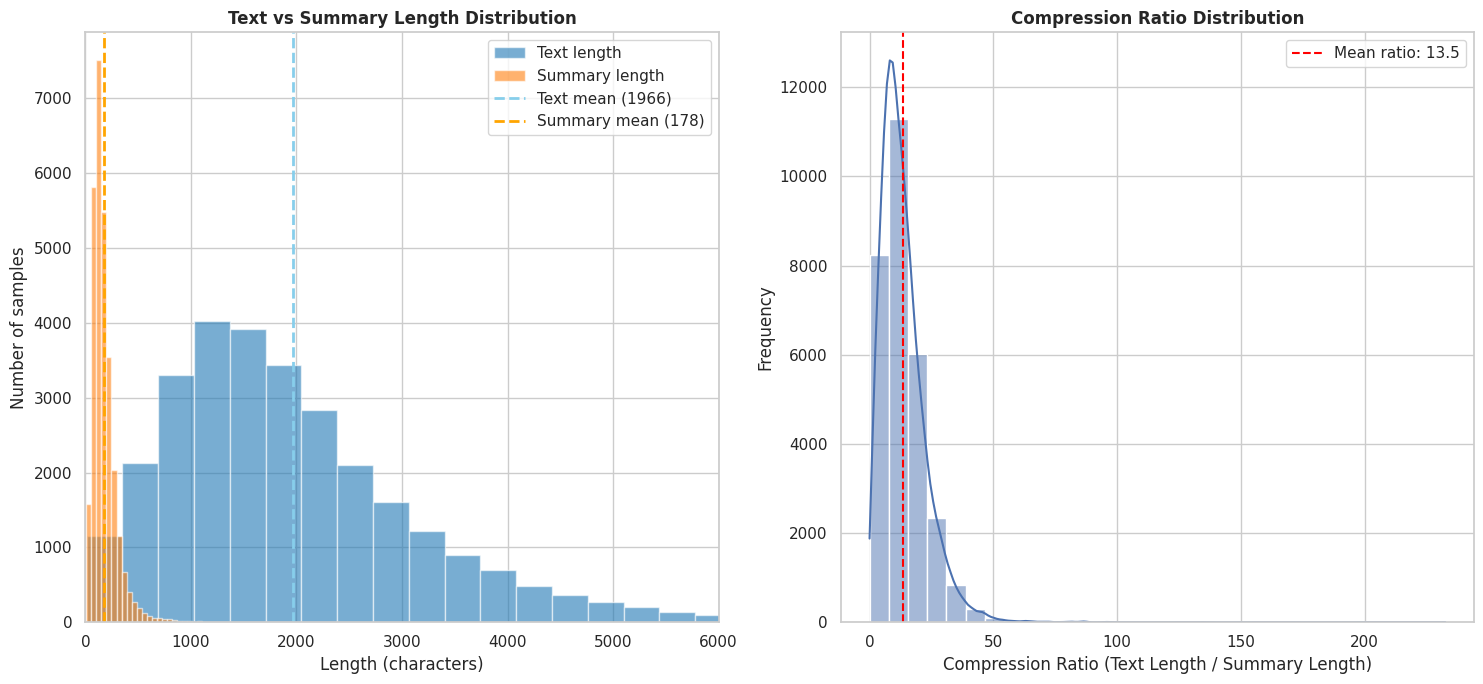

In [ ]:
# assume df already has summary_length & text_length
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

text_mean = summarization_df["text_length"].mean()
summary_mean = summarization_df["summary_length"].mean()

# Length distribution
ax1.hist(
    summarization_df["text_length"],
    bins=50,
    alpha=0.6,
    label="Text length",
    color="#1f77b4",
)
ax1.hist(
    summarization_df["summary_length"],
    bins=50,
    alpha=0.6,
    label="Summary length",
    color="#ff7f0e",
)

ax1.set_xlim(0, 6000)
ax1.axvline(
    text_mean,
    color="skyblue",
    linestyle="--",
    linewidth=2,
    label=f"Text mean ({text_mean:.0f})",
)
ax1.axvline(
    summary_mean,
    color="orange",
    linestyle="--",
    linewidth=2,
    label=f"Summary mean ({summary_mean:.0f})",
)

ax1.set_xlabel("Length (characters)")
ax1.set_ylabel("Number of samples")
ax1.set_title("Text vs Summary Length Distribution", fontweight="bold")
ax1.legend()

# Compression ratio
compression_ratio = summarization_df["text_length"] / summarization_df["summary_length"]
sns.histplot(compression_ratio, bins=30, kde=True, ax=ax2)
ax2.set_title("Compression Ratio Distribution", fontweight="bold")
ax2.set_xlabel("Compression Ratio (Text Length / Summary Length)")
ax2.set_ylabel("Frequency")
ax2.axvline(
    compression_ratio.mean(),
    color="red",
    linestyle="--",
    label=f"Mean ratio: {compression_ratio.mean():.1f}",
)
ax2.legend()

plt.tight_layout()
plt.show()

### Data Characteristics Insights

**KALIMAT Corpus Observations**:
- Somewhat imbalanced class distribution with sports articles dominating (~25% of dataset)
- Text lengths vary significantly across topics (economics articles tend to be longer)
- Average Arabic text contains ~450 words, requiring careful sequence length management for neural models

**Summarization Corpus Patterns**:
- High compression ratios (13.5) which means summarization is much shorter
- Length variability suggests diverse text types and summarization styles
- Arabic summary quality appears inconsistent, affecting evaluation metrics

These patterns inform preprocessing decisions and model architecture choices.





## 3. Phase 1: Traditional Approaches

In [ ]:
print("Creating train/test splits on preprocessed text...")

# Classification data split
X_cls = classification_df["preprocessed_text"]
y_cls = classification_df["label"]
X_cls_train_raw, X_cls_test_raw, y_cls_train_raw, y_cls_test_raw = train_test_split(
    X_cls, y_cls, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y_cls
)

# Preserve original string labels
y_cls_train_str = y_cls_train_raw.copy()
y_cls_test_str = y_cls_test_raw.copy()

# Encode labels
label_encoder = LabelEncoder()
y_cls_train_raw = label_encoder.fit_transform(y_cls_train_raw)
y_cls_test_raw = label_encoder.transform(y_cls_test_raw)

print(
    f"Classification split - Training: {len(X_cls_train_raw):,}, Test: {len(X_cls_test_raw):,}"
)
print(f"Label classes: {list(label_encoder.classes_)}")

Creating train/test splits on preprocessed text...
Classification split - Training: 12,176, Test: 3,045
Label classes: ['culture', 'economy', 'international', 'local', 'religion', 'sports']


### Traditional implementation of Task 1

In [ ]:
print("Training traditional SVM model...")

X_cls_train_preprocessed = X_cls_train_raw.tolist()
X_cls_test_preprocessed = X_cls_test_raw.tolist()

# Check if TF-IDF vectorizer exists
svm_tfidf_path = os.path.join(
    MODEL_SAVE_DIR, "traditional_tfidf_vectorizer_classifier.joblib"
)

if os.path.exists(svm_tfidf_path):
    print("Loading existing TF-IDF vectorizer for classification...")
    svm_vectorizer = joblib.load(svm_tfidf_path)
    X_cls_train_tfidf = svm_vectorizer.transform(X_cls_train_preprocessed)
    X_cls_test_tfidf = svm_vectorizer.transform(X_cls_test_preprocessed)
    print("✓ TF-IDF vectorizer loaded from file")
else:
    print("Creating new TF-IDF vectorizer...")
    # Create TF-IDF features
    svm_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
    X_cls_train_tfidf = svm_vectorizer.fit_transform(X_cls_train_preprocessed)
    X_cls_test_tfidf = svm_vectorizer.transform(X_cls_test_preprocessed)

    # Save the vectorizer
    joblib.dump(svm_vectorizer, svm_tfidf_path)
    print("✓ TF-IDF vectorizer created and saved")

print(f"TF-IDF feature matrix shape: {X_cls_train_tfidf.shape}")

Training traditional SVM model...
Loading existing TF-IDF vectorizer for classification...
✓ TF-IDF vectorizer loaded from file
TF-IDF feature matrix shape: (12176, 10000)


In [ ]:
# Check if model exists
svm_model_path = os.path.join(MODEL_SAVE_DIR, "traditional_svm_classifier.joblib")

if os.path.exists(svm_model_path):
    print("Loading existing SVM model...")
    svm_model = joblib.load(svm_model_path)
    print("✓ SVM model loaded from file")
else:
    print("Training new SVM model...")
    svm_model = SVC(kernel="linear", C=1, random_state=RANDOM_SEED)
    svm_model.fit(X_cls_train_tfidf, y_cls_train_raw)

    # Save the model
    joblib.dump(svm_model, svm_model_path)
    print("✓ SVM model trained and saved")

svm_preds = svm_model.predict(X_cls_test_tfidf)

Loading existing SVM model...
✓ SVM model loaded from file


### Traditional implementation of Task 2

In [ ]:
summarization_train_df, summarization_test_df = train_test_split(
    summarization_df, test_size=TEST_SIZE, random_state=RANDOM_SEED
)

X_sum_train = summarization_train_df["text"].tolist()
X_sum_test = summarization_test_df["text"].tolist()
y_sum_train = summarization_train_df["summary"].tolist()
y_sum_test = summarization_test_df["summary"].tolist()

#  Preprocess
X_sum_train = [preprocess_for_summarization(t) for t in X_sum_train]
X_sum_test = [preprocess_for_summarization(t) for t in X_sum_test]
y_sum_train = [preprocess_for_summarization(t) for t in y_sum_train]
y_sum_test = [preprocess_for_summarization(t) for t in y_sum_test]

print(f"Summarization split - Training: {len(X_sum_train)}, Test: {len(X_sum_test)}")

Summarization split - Training: 23353, Test: 5839


In [ ]:
def create_tfidf_vectorizer(corpus):
    vectorizer = TfidfVectorizer(stop_words=None, max_features=5000)
    vectorizer.fit(corpus)
    return vectorizer


def extract_tfidf_summary(text, vectorizer, num_sentences=3):
    cleaned_text = preprocess_for_summarization(text)
    sentences = re.split(r"[.!؟\n]+", cleaned_text)
    sentences = [s.strip() for s in sentences if s.strip() and len(s.split()) > 3]

    if len(sentences) <= num_sentences:
        return " ".join(sentences)

    try:
        tfidf_matrix = vectorizer.transform(sentences)
        sentence_scores = tfidf_matrix.sum(axis=1).A1
        top_indices = np.argsort(sentence_scores)[-num_sentences:][::-1]
        summary_sentences = [sentences[i] for i in sorted(top_indices)]
        return ". ".join(summary_sentences) + "."
    except:
        return ". ".join(sentences[:num_sentences]) + "."


print("✓ Traditional summarization functions loaded!")

✓ Traditional summarization functions loaded!


In [ ]:
print("Setting up TF-IDF vectorizer for summarization...")

# Check if TF-IDF vectorizer for summarization exists
tfidf_sum_path = os.path.join(
    MODEL_SAVE_DIR, "traditional_tfidf_vectorizer_summarization.joblib"
)

if os.path.exists(tfidf_sum_path):
    print("Loading existing TF-IDF vectorizer for summarization...")
    tfidf_vectorizer = joblib.load(tfidf_sum_path)
    print("✓ TF-IDF vectorizer loaded from file")
else:
    print("Training new TF-IDF vectorizer for summarization...")

    # Use training set for fitting the vectorizer
    train_texts_clean = [
        preprocess_for_summarization(text)
        for text in tqdm(X_sum_train, desc="Preprocessing training texts")
    ]

    tfidf_vectorizer = create_tfidf_vectorizer(train_texts_clean)

    # Save the vectorizer
    joblib.dump(tfidf_vectorizer, tfidf_sum_path)
    print("✓ TF-IDF vectorizer created and saved")

print(f"TF-IDF vocabulary size: {len(tfidf_vectorizer.vocabulary_):,}")
print("✓ TF-IDF vectorizer ready!")

Setting up TF-IDF vectorizer for summarization...
Loading existing TF-IDF vectorizer for summarization...
✓ TF-IDF vectorizer loaded from file
TF-IDF vocabulary size: 5,000
✓ TF-IDF vectorizer ready!


In [ ]:
tfidf_summaries = []
for text in tqdm(X_sum_test, desc="Generating TF-IDF summaries"):
    summary = extract_tfidf_summary(text, tfidf_vectorizer, num_sentences=3)
    tfidf_summaries.append(summary)

print(f"Generated {len(tfidf_summaries):,} TF-IDF summaries")

Generating TF-IDF summaries: 100%|██████████| 5839/5839 [00:07<00:00, 820.74it/s]

Generated 5,839 TF-IDF summaries


In [ ]:
print("\nSample TF-IDF summary:")
sample_idx = 0
print_text_sample(X_sum_test[sample_idx], "Original Text")
print_text_sample(y_sum_test[sample_idx], "Reference Summary")
print_text_sample(tfidf_summaries[sample_idx], "TF-IDF Summary")


Sample TF-IDF summary:

Original Text:


ما بين تجهيز نفسك، أو العناية بالحيوانات الأليفة والأطفال أو القيام بالمهام المنزلية السابقة للعمل، أنت منشغل بمهام كثيرة في الصباح. قلل الحمل عن طريق تحضير الفطور والغذاء الليلة السابقة. عندما يكون كل ما تحتاجه هو أن تأخذ الوجبة وتذهب، أنت تقلل من فرص أن تتجاهل الفطور لأنك في عجلة من أمرك وستتجنب شراء الأطعمة السريعة الغير صحية للغذاء. أبق مستويات طاقاتك عالية. الطاقة التي حصلت عليها من تناول العشاء الليلة السابقة تنفذ مع الصباح. تناول فطور يحتوي على نسبة عالية من الألياف يوازن مستوى سكر الدم لديك، مما يساعدك على الشعور بالطاقة والمزيد من التركيز. تحتاج إلى طاقة لأقصى كم من التحفيز في الصباح وطوال اليوم. تجنب الكربوهيدرات المكررة مثل الكعك لأنها ترفع سكر الدم بشكل مفاجئ ثم يهبط فجأة. ابق فطورك بسيطا ومغذيا. اسلق البيض وضعه في الثلاجة ليكون متاحا في الصباحات المشغولة. استمتع ببيض مسلوق مع مافن انجليزي وثمرة موز لفطور متوازن. كخيار آخر يمكنك طهي الشوفان في الطاهي البطيء ليلا. استمتع بشوفان ساخن وفواكه في الصباح واحتفظ بالباقي في الثلاجة لفطور سريع باقي الأسبوع. جهز غداء متوازن. استخدم وعاء واسع الفم لصنع سلطة عالية البروتين. ضع تتبيلة السلطة في قاع الوعاء. بعد ذلك، رتب الخضروات في طبقات كالخيار، الطماطم الكرز، الجزر، والحمص. أضف بروتين خالي من الدهون كالدجاج المشوي. أخيرا أضف الخضروات الورقية على السطح، اغلق الوعاء وضعه في الثلاجة. ستبقى السلطة طازجة طوال الليل بما أن الخضروات مفصولة عن التتبيلة. عندما تكون مستعدا لتناول الغداء، قم فقط برج الوعاء لتوزيع التتبيلة ثم اسكبها في طبق. يستخدم جسمك طعام العشاء كوقود أثناء النوم. ستستيقظ بطاقة وحماس أكبر عندما تقوم شحن جسمك بالأطعمة الصحيحة في الليلة السابقة. تناول البروتينات خالية الدهون مثل الدجاج المشوي، السمك أو الفول. أضف الخضروات والكربوهيدرات المعقدة مثل الأرز البني أو الكينوا. يستخدم جسمك الكثير من الطاقة لهضم الطعام. تناول وجبة دسمة قرب وقت النوم يصعب من عملية النوم. تناول الطعام قبل النوم بساعتين أو ثلاث ساعات. هذا يعطي جسمك وقتا لإنهاء الهضم قبل أن تنام. تجنب الأطعمة السكرية أو الدسمة لأنها تؤدي إلى رفع معدل سكر الدم فجأة أو حرقة المعدة. كلا الأمران يصعب من النوم. التابلت، والتليفون الذكي، والحاسوب، والتلفاز كلها أشياء تحفز العقل. أنت في مزاج تفكير بدلا من مزاج استرخاء. العقل المحفز يصعب النوم. عندما يتشتت نومك، سيصعب عليك البقاء أن تصبح محفزا في الصباح. اغلق كل الأجهزة الالكترونية قبل النوم بساعة على الأقل. الإضاءة الاصطناعية التي تأتي من الأجهزة الالكترونية تصيب الساعة البيولوجية بالاضطراب. كذلك تكبح هرمون النوم الميلاتونين، الذي يجعلك تبقى مستيقظا لفترة أطول. النوم المشوش يعني أنك تشعر بالكسل والانزعاج في الصباح. الكافيين يبقيك منتبها لعدة ساعات. ستحتاج إلى وقت أطول للنوم وستعاني من النوم المتقطع عندما تستهلك الكافيين ليلا. ستستيقظ شاعرا بالترنح بدلا من النشاط. تجنب المشروبات التي تحتوي على كافيين كالقهوة، الشاي، أو الصودا لمدة أربع ساعات على الأقل قبل موعد النوم. اشرب مشروبات لا تحتوي على كافيين كبديل مثل الشاي اخالي من الكافيين أو الحليب الدافئ. لهذا تأثير مهدئ. سيكون النوم والبقاء نائما أسهل عليك. شرب كأس أخير قبل النوم لا يبعث على الاسترخاء كما تظن. الكحول هو مسبب للاكتئاب لذا يجعلك تشعر بالنعاس أولا. عندما يختفي مفعول الكحول، له تأثير محفز. ستستيقظ وتشعر بصعوبة النوم مجددا. الكحول يسبب اضطرابا في دورات نومك أيضا، لذا لن تحصل على نوع النوم الذي تحتاجه للشعور بالراحة. قلل الكحول إلى كأس أو اثنين يوميا. اشرب اخر مشروب قبل النوم بساعتين على الأقل. روتين النوم ليس فقط للأطفال. درب عقلك وجسمك على النوم والبقاء نائما. الراحة جيدا أساسية لبدء صباحك شاعرا بالطاقة والتركيز. اقرأ كتابا أو مجلة قديمة. ستتعب عقلك وتنام بسهولة بشكل أسهل عندما تقرأ. تجنب القراءة من جهاز إلكتروني لأن ضوء الجهاز يمكن أن يبقيك مستيقظا. بالإضافة إلى ذلك، ستشعر بالرغبة في التحقق من رسائلك أو تطبيقاتك. أرخ عضلاتك. أخذ حمام دافئ أو القيام بتمديد العضلات اللطيف هي بعض الطرق التي يمكن أن تساعدك على تخفيف الضغط من جسمك. عضلاتك مشدودة بسبب يومك المشغول. الحمام أو تمديد عضلاتك يساعدك على الراحة والاستغراق في النوم. اهدف إلى سبع إلى تسع ساعات من النوم كل ليلة. هذه الكمية ستسمح لك أن تمر بكل دورات النوم. هناك أربع مراحل من النوم تتكرر حوالي كل  دقيقة. إذا كنت تنام أقل من سبع ساعات، لا يمكنك المرور خلال كل المراحل. اعلم أن النوم مهم لصحتك العامة. الحرمان من النوم يؤدي إلى فقدان الذاكرة، وقلة التركيز والإعياء. النوم جيدا بشكل منتظم يحفز نظامك المناعي ويساعدك على التحكم في وزنك. الراحة ليلا تحسن طاقتك، تحفيزك وصحتك العامة.


[Full length: 4,110 characters]


Reference Summary:


حضر فطورك وغذائك الليلة السابقة. تناول عشاءا صحيا. اغلق الأجهزة الكهربائية قبل النوم. تجنب الكافيين قبل النوم. تجنب الكحول قبل النوم. رتب روتينا للنوم.


[Full length: 151 characters]


TF-IDF Summary:


عندما يكون كل ما تحتاجه هو أن تأخذ الوجبة وتذهب، أنت تقلل من فرص أن تتجاهل الفطور لأنك في عجلة من أمرك وستتجنب شراء الأطعمة السريعة الغير صحية للغذاء. تناول فطور يحتوي على نسبة عالية من الألياف يوازن مستوى سكر الدم لديك، مما يساعدك على الشعور بالطاقة والمزيد من التركيز. أخذ حمام دافئ أو القيام بتمديد العضلات اللطيف هي بعض الطرق التي يمكن أن تساعدك على تخفيف الضغط من جسمك.


[Full length: 374 characters]



### Evaluation and results analysis

#### Task 1

SVM Classification Results:


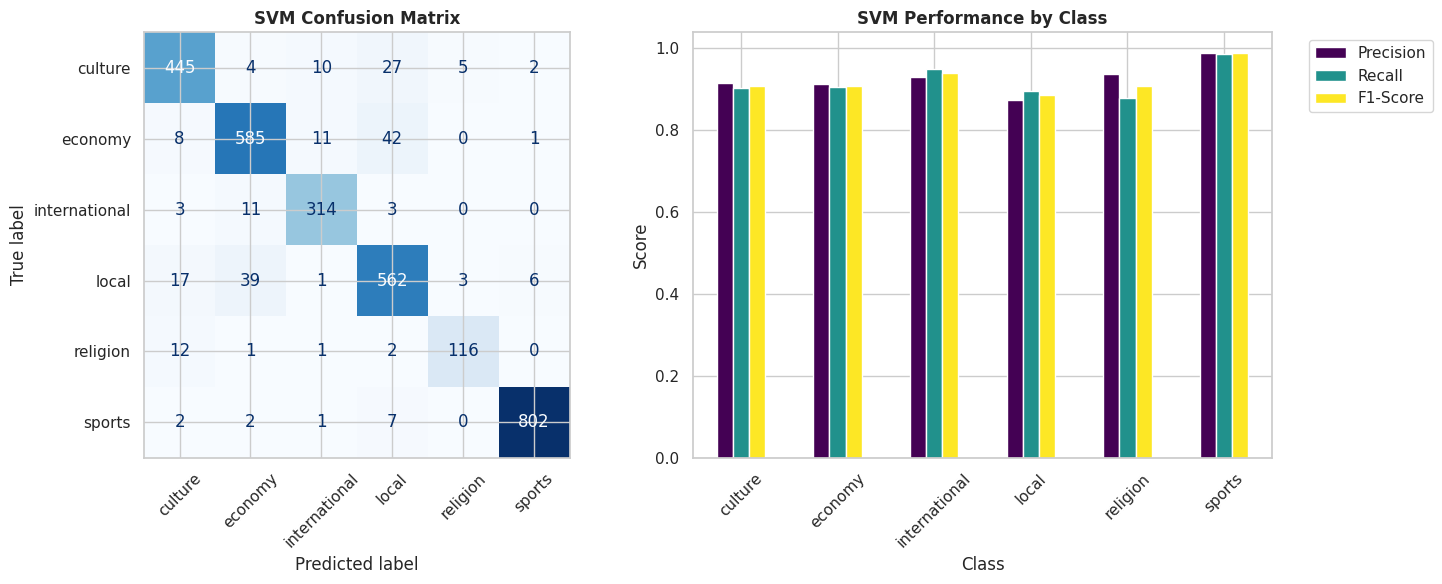

In [ ]:
print("SVM Classification Results:")
print("=" * 40)

labels = list(label_encoder.classes_)

svm_preds = label_encoder.inverse_transform(svm_preds)
# Confusion Matrix
cm_svm = confusion_matrix(y_cls_test_str, svm_preds, labels=labels)
svm_accuracy = cm_svm.diagonal().sum() / cm_svm.sum()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=labels)
disp.plot(cmap="Blues", ax=ax1, colorbar=False)
ax1.set_title("SVM Confusion Matrix", fontweight="bold")
ax1.tick_params(axis="x", rotation=45)

# Classification metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_cls_test_str, svm_preds, labels=labels, zero_division=0
)

metrics_df = pd.DataFrame(
    {
        "Class": labels,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "Support": support,
    }
)

metrics_df.set_index("Class")[["Precision", "Recall", "F1-Score"]].plot(
    kind="bar", ax=ax2, colormap="viridis"
)
ax2.set_title("SVM Performance by Class", fontweight="bold")
ax2.set_ylabel("Score")
ax2.tick_params(axis="x", rotation=45)
ax2.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

In [ ]:
print("\n=== SVM Classification Report ===")
print(classification_report(y_cls_test_str, svm_preds, labels=labels))


=== SVM Classification Report ===
               precision    recall  f1-score   support

      culture       0.91      0.90      0.91       493
      economy       0.91      0.90      0.91       647
international       0.93      0.95      0.94       331
        local       0.87      0.89      0.88       628
     religion       0.94      0.88      0.91       132
       sports       0.99      0.99      0.99       814

     accuracy                           0.93      3045
    macro avg       0.93      0.92      0.92      3045
 weighted avg       0.93      0.93      0.93      3045



#### Task 2

In [ ]:
print("Evaluating TF-IDF Summarization:")
print("=" * 40)

# Calculate ROUGE scores
scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=False)

rouge_scores = {"rouge1": [], "rouge2": [], "rougeL": []}

print("Calculating ROUGE scores...")
for reference, generated in tqdm(
    zip(y_sum_test, tfidf_summaries), total=len(y_sum_test), desc="ROUGE evaluation"
):
    reference = str(reference)
    generated = str(generated)

    if reference and generated:
        scores = scorer.score(reference, generated)
        for metric in rouge_scores:
            rouge_scores[metric].append(scores[metric].fmeasure)

# Calculate and display results
rouge_results = {}
for metric in rouge_scores:
    rouge_results[metric] = np.mean(rouge_scores[metric])

print("\nTF-IDF Summarization Results:")
for metric, score in rouge_results.items():
    print(f"{metric.upper()}: {score:.4f}")

# BLEU Score calculation
print("\nCalculating BLEU scores...")
smooth = SmoothingFunction().method1
refs = [[ref.split()] for ref in y_sum_test]
cands = [cand.split() for cand in tfidf_summaries]

bleu_scores = {
    "BLEU-1": corpus_bleu(refs, cands, weights=(1, 0, 0, 0), smoothing_function=smooth),
    "BLEU-2": corpus_bleu(
        refs, cands, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth
    ),
    "BLEU-3": corpus_bleu(
        refs, cands, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth
    ),
    "BLEU-4": corpus_bleu(
        refs, cands, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth
    ),
}

for metric, score in bleu_scores.items():
    print(f"{metric}: {score:.4f}")

traditional_results = {
    "SVM_Accuracy": classification_report(
        label_encoder.inverse_transform(y_cls_test_raw), svm_preds, output_dict=True
    )["accuracy"],
    "TF-IDF_ROUGE1": rouge_results["rouge1"],
    "TF-IDF_BLEU1": bleu_scores["BLEU-1"],
}

print("\n✓ Traditional methods evaluation complete!")

Evaluating TF-IDF Summarization:
Calculating ROUGE scores...


ROUGE evaluation: 100%|██████████| 5839/5839 [00:05<00:00, 1150.58it/s]



TF-IDF Summarization Results:
ROUGE1: 0.1327
ROUGE2: 0.0301
ROUGEL: 0.0957

Calculating BLEU scores...
BLEU-1: 0.0776
BLEU-2: 0.0340
BLEU-3: 0.0176
BLEU-4: 0.0090

✓ Traditional methods evaluation complete!


In [ ]:
print("Sample Traditional Summarization Results:")
print("=" * 50)

for i in [0, 1, 2]:
    print(f"\n--- Sample {i + 1} ---")
    print_text_sample(X_sum_test[i], "Original Text")
    print_text_sample(y_sum_test[i], "Reference Summary")
    print_text_sample(tfidf_summaries[i], "TF-IDF Generated Summary")
    print("-" * 50)

Sample Traditional Summarization Results:

--- Sample 1 ---

Original Text:


ما بين تجهيز نفسك، أو العناية بالحيوانات الأليفة والأطفال أو القيام بالمهام المنزلية السابقة للعمل، أنت منشغل بمهام كثيرة في الصباح. قلل الحمل عن طريق تحضير الفطور والغذاء الليلة السابقة. عندما يكون كل ما تحتاجه هو أن تأخذ الوجبة وتذهب، أنت تقلل من فرص أن تتجاهل الفطور لأنك في عجلة من أمرك وستتجنب شراء الأطعمة السريعة الغير صحية للغذاء. أبق مستويات طاقاتك عالية. الطاقة التي حصلت عليها من تناول العشاء الليلة السابقة تنفذ مع الصباح. تناول فطور يحتوي على نسبة عالية من الألياف يوازن مستوى سكر الدم لديك، مما يساعدك على الشعور بالطاقة والمزيد من التركيز. تحتاج إلى طاقة لأقصى كم من التحفيز في الصباح وطوال اليوم. تجنب الكربوهيدرات المكررة مثل الكعك لأنها ترفع سكر الدم بشكل مفاجئ ثم يهبط فجأة. ابق فطورك بسيطا ومغذيا. اسلق البيض وضعه في الثلاجة ليكون متاحا في الصباحات المشغولة. استمتع ببيض مسلوق مع مافن انجليزي وثمرة موز لفطور متوازن. كخيار آخر يمكنك طهي الشوفان في الطاهي البطيء ليلا. استمتع بشوفان ساخن وفواكه في الصباح واحتفظ بالباقي في الثلاجة لفطور سريع باقي الأسبوع. جهز غداء متوازن. استخدم وعاء واسع الفم لصنع سلطة عالية البروتين. ضع تتبيلة السلطة في قاع الوعاء. بعد ذلك، رتب الخضروات في طبقات كالخيار، الطماطم الكرز، الجزر، والحمص. أضف بروتين خالي من الدهون كالدجاج المشوي. أخيرا أضف الخضروات الورقية على السطح، اغلق الوعاء وضعه في الثلاجة. ستبقى السلطة طازجة طوال الليل بما أن الخضروات مفصولة عن التتبيلة. عندما تكون مستعدا لتناول الغداء، قم فقط برج الوعاء لتوزيع التتبيلة ثم اسكبها في طبق. يستخدم جسمك طعام العشاء كوقود أثناء النوم. ستستيقظ بطاقة وحماس أكبر عندما تقوم شحن جسمك بالأطعمة الصحيحة في الليلة السابقة. تناول البروتينات خالية الدهون مثل الدجاج المشوي، السمك أو الفول. أضف الخضروات والكربوهيدرات المعقدة مثل الأرز البني أو الكينوا. يستخدم جسمك الكثير من الطاقة لهضم الطعام. تناول وجبة دسمة قرب وقت النوم يصعب من عملية النوم. تناول الطعام قبل النوم بساعتين أو ثلاث ساعات. هذا يعطي جسمك وقتا لإنهاء الهضم قبل أن تنام. تجنب الأطعمة السكرية أو الدسمة لأنها تؤدي إلى رفع معدل سكر الدم فجأة أو حرقة المعدة. كلا الأمران يصعب من النوم. التابلت، والتليفون الذكي، والحاسوب، والتلفاز كلها أشياء تحفز العقل. أنت في مزاج تفكير بدلا من مزاج استرخاء. العقل المحفز يصعب النوم. عندما يتشتت نومك، سيصعب عليك البقاء أن تصبح محفزا في الصباح. اغلق كل الأجهزة الالكترونية قبل النوم بساعة على الأقل. الإضاءة الاصطناعية التي تأتي من الأجهزة الالكترونية تصيب الساعة البيولوجية بالاضطراب. كذلك تكبح هرمون النوم الميلاتونين، الذي يجعلك تبقى مستيقظا لفترة أطول. النوم المشوش يعني أنك تشعر بالكسل والانزعاج في الصباح. الكافيين يبقيك منتبها لعدة ساعات. ستحتاج إلى وقت أطول للنوم وستعاني من النوم المتقطع عندما تستهلك الكافيين ليلا. ستستيقظ شاعرا بالترنح بدلا من النشاط. تجنب المشروبات التي تحتوي على كافيين كالقهوة، الشاي، أو الصودا لمدة أربع ساعات على الأقل قبل موعد النوم. اشرب مشروبات لا تحتوي على كافيين كبديل مثل الشاي اخالي من الكافيين أو الحليب الدافئ. لهذا تأثير مهدئ. سيكون النوم والبقاء نائما أسهل عليك. شرب كأس أخير قبل النوم لا يبعث على الاسترخاء كما تظن. الكحول هو مسبب للاكتئاب لذا يجعلك تشعر بالنعاس أولا. عندما يختفي مفعول الكحول، له تأثير محفز. ستستيقظ وتشعر بصعوبة النوم مجددا. الكحول يسبب اضطرابا في دورات نومك أيضا، لذا لن تحصل على نوع النوم الذي تحتاجه للشعور بالراحة. قلل الكحول إلى كأس أو اثنين يوميا. اشرب اخر مشروب قبل النوم بساعتين على الأقل. روتين النوم ليس فقط للأطفال. درب عقلك وجسمك على النوم والبقاء نائما. الراحة جيدا أساسية لبدء صباحك شاعرا بالطاقة والتركيز. اقرأ كتابا أو مجلة قديمة. ستتعب عقلك وتنام بسهولة بشكل أسهل عندما تقرأ. تجنب القراءة من جهاز إلكتروني لأن ضوء الجهاز يمكن أن يبقيك مستيقظا. بالإضافة إلى ذلك، ستشعر بالرغبة في التحقق من رسائلك أو تطبيقاتك. أرخ عضلاتك. أخذ حمام دافئ أو القيام بتمديد العضلات اللطيف هي بعض الطرق التي يمكن أن تساعدك على تخفيف الضغط من جسمك. عضلاتك مشدودة بسبب يومك المشغول. الحمام أو تمديد عضلاتك يساعدك على الراحة والاستغراق في النوم. اهدف إلى سبع إلى تسع ساعات من النوم كل ليلة. هذه الكمية ستسمح لك أن تمر بكل دورات النوم. هناك أربع مراحل من النوم تتكرر حوالي كل  دقيقة. إذا كنت تنام أقل من سبع ساعات، لا يمكنك المرور خلال كل المراحل. اعلم أن النوم مهم لصحتك العامة. الحرمان من النوم يؤدي إلى فقدان الذاكرة، وقلة التركيز والإعياء. النوم جيدا بشكل منتظم يحفز نظامك المناعي ويساعدك على التحكم في وزنك. الراحة ليلا تحسن طاقتك، تحفيزك وصحتك العامة.


[Full length: 4,110 characters]


Reference Summary:


حضر فطورك وغذائك الليلة السابقة. تناول عشاءا صحيا. اغلق الأجهزة الكهربائية قبل النوم. تجنب الكافيين قبل النوم. تجنب الكحول قبل النوم. رتب روتينا للنوم.


[Full length: 151 characters]


TF-IDF Generated Summary:


عندما يكون كل ما تحتاجه هو أن تأخذ الوجبة وتذهب، أنت تقلل من فرص أن تتجاهل الفطور لأنك في عجلة من أمرك وستتجنب شراء الأطعمة السريعة الغير صحية للغذاء. تناول فطور يحتوي على نسبة عالية من الألياف يوازن مستوى سكر الدم لديك، مما يساعدك على الشعور بالطاقة والمزيد من التركيز. أخذ حمام دافئ أو القيام بتمديد العضلات اللطيف هي بعض الطرق التي يمكن أن تساعدك على تخفيف الضغط من جسمك.


[Full length: 374 characters]

--------------------------------------------------

--- Sample 2 ---

Original Text:


تتخطى العديد من الماسحات وتصدر صريرا بسبب أن الزجاج الأمامي غير رطب بشكل كاف، لذلك تحقق من مستوى سائل الماسحة واملأه عند الحاجة؛ بهذه الطريقة ستكون البخاخات مستعدة للعمل إذا حدث الصرير. ماسحات الزجاج الأمامي مصممة لاتباع حركة ذراع الماسحة، لذلك إذا كانت الشفرات متصلبة ولا تتحرك خلف الذراع ذهابا وإيابا، لف الذراع بيدك لترخية صلابتها. لن تتمكن الشفرات المثبتة بإحكام شديد من التحرك ذهابا وإيابا لتتبع ذراع الماسحة بسلاسة مما يسبب احتكاكها وإحداث الصرير. ينبغي ألا تبدو شفرات الماسحة وكأنها تحفر خلال الزجاج الأمامي أو تظل عمودية أثناء المسح عليه. تسبب شفرات الماسحة الخشنة صوت حكة وصرير وقد تكون بعض شفرات الماسحة الجديدة خشنة منذ البداية، بينما قد تصبح أخرى خشنة نتيجة التعرض للعناصر المختلفة. ينبغي تغيير الشفرات التي قد مر عليها عاما كما يمكن تليين الشفرات الجديدة بواسطة ما يلي: منتج تنظيف السيارات (أرمور أول). ضع كمية وفيرة على منشفة ورقية واستخدم حركات دائرية مع تمرير المنتج على مطاط شفرة الماسحة لتنعيمها. الكحول المحمر. بلل منشفة ورقية بالكحول المحمر ولمع مطاط الشفرة برفق. منتج wd-. استخدم ذلك المنتج بحرص إذ قد يسبب الكثير منه تجفيف المطاط. رش القليل من المنتج على منشفة ورقية ومررها برفق على مطاط الشفرة ثم جففه. افحص لترى إذا كانت الشفرات أو أجزاء الماسحة الموجودة أدناها مرتخية جدا أو مربوطة جدا؛ قد يسبب الاحتكاك القليل أو الكثير جدا بين الزجاج والماسحة إصدار صوت الاحتكاك والصرير. يمكن ربط البراغي بإحكام في العموم باستخدام مفتاح البراغي عن طريق لفه باتجاه عقارب الساعة وترخيتها عن طريق لفه باتجاه معاكس لحركة عقارب الساعة. قد تحتاج إلى اختبار مستوى الربط لتجد ما يعمل أفضل؛ من الأمثل أن تكون الشفرات مثبتة في موضعها جيدا لكن ينبغي أن تزال مرتخية بشكل كاف لتتمكن من المسح ذهابا وإيابا على زجاج السيارة. قد تسبب بعض الدهانات الواقية للسطح، مثل الطلاء الواقي من المطر أو بعض أنواع الشمع الاحتكاك والصرير. أزل المنتج وقلل من صوت الماسحة المزعج عن طريق استخدام ملمع السيارة العادي. قد يسبب الطلاء المتروك بواسطة بعض منتجات سطح السيارات زيادة الاحتكاك بين شفرات الماسحة والزجاج الأمامي للسيارة محدثا الأصوات المزعجة، مثل الصرير.


[Full length: 1,940 characters]


Reference Summary:


أعد ملء سائل ماسحة الزجاج الأمامي. اضبط موضع شفرات الماسحات حسب الحاجة. لين ماسحات الزجاج الأمامي. اضبط إحكام البراغي. أزل الأغلفة المسببة لزيادة الاحتكاك.


[Full length: 155 characters]


TF-IDF Generated Summary:


تتخطى العديد من الماسحات وتصدر صريرا بسبب أن الزجاج الأمامي غير رطب بشكل كاف، لذلك تحقق من مستوى سائل الماسحة واملأه عند الحاجة؛ بهذه الطريقة ستكون البخاخات مستعدة للعمل إذا حدث الصرير. ينبغي تغيير الشفرات التي قد مر عليها عاما كما يمكن تليين الشفرات الجديدة بواسطة ما يلي: منتج تنظيف السيارات (أرمور أول). قد تحتاج إلى اختبار مستوى الربط لتجد ما يعمل أفضل؛ من الأمثل أن تكون الشفرات مثبتة في موضعها جيدا لكن ينبغي أن تزال مرتخية بشكل كاف لتتمكن من المسح ذهابا وإيابا على زجاج السيارة.


[Full length: 485 characters]

--------------------------------------------------

--- Sample 3 ---

Original Text:


تحتاج بالضرورة إلى نسخة مسجلة من أغنياتك، حتى ولو بشكل تجريبي، لتقدر على لفت انتباه شركات الإنتاج والتوزيع، كما أن المعجبين سيحبون سماع أغنيتك بنسخة الأستديو بدلا من التسجيل متوسط المستوى من الحفلات أو التسجيلات العادية، لذا انشر لهم نسخة من تسجيلاتك في الأستديو لأغنياتك المشهورة، وكذلك القليل من الأغنيات الجديدة التي لم يسبق لهم سماعها من قبل. تختلف تكلفة الساعة في أستديوهات التسجيل من أستديو لآخر ومن مدينة لأخرى. اسأل عن الأسعار في مدينتك، مع ملاحظة أنه توجد تكلفة من أجل عملية التسجيل الأساسية، وتكلفة إضافية مكلفة أكثر من أجل عمليات المكساج والتحسين (ماسترينغ). قد تكون التكلفة المالية باهظة ولا تقدر على تحملها، لذا من الأفضل أن تجعل تسجيلاتك التجريبية مقتصرة على واحدة أو اثنين من أفضل أغانيك، جاعلا كل تركيزك منصبا على تسجيل الأغنيتين بكفاءة وبأعلى جودة ممكنة، وفي أقل وقت ممكن (من أجل تقليل النفقات التي تدفعها للأستديو نظير كل ساعة تأجير). لكل مهندس أو منتج صوتي أسلوبه المختلف في تنظيم جلسات التسجيل، لكن يفضل أن تحرص بدورك على إتمام مهمتك (تسجيل الأغنية) في الأستديو بفاعلية وسرعة قدر الإمكان. طالما أنك تعلم طبيعة الأغنية عن ظهر قلب، وتعرف ما ترغب في تقديمه بها من كلمات وألحان وتوزيع، فعلى الأغلب لن تحتاج للتجريب أو التسجيل أكثر من مرة من أجل الوصول لأفضل نتيجة. أجر عملية دراسة مسبقة للتعرف على طريقة تسجيل الأغنيات والمعدات المتاحة للاستخدام في الأستديوهات قبل الحجز. على سبيل المثال، يجب أن تتفق مع فرقتك الموسيقية حول ما إذا كان الأفضل لهم هو التسجيل سويا في نفس الوقت أم التسجيل لكل منهم بشكل منفرد، وكذلك مختلف خيارات التسجيل التي ترغب في أن يلتزم مهندس الصوت بتطبيقها. لا تقم أبدا بالتسجيل بواسطة معدات غير مألوفة بالنسبة لك. من المغري للغاية الخضوع لرغبة حجز معدات وآلات موسيقية فاخرة وغالية الثمن، طمعا في استخدامها ولو لمرة واحدة وظنا أنها كافية بحد ذاتها لتسجيل أغنية خيالية، لكن التعامل مع معدات مجهولة سوف يستهلك وقتك في الأستديو دون الحصول على أي نتائج مجدية. لن تستفيد كثيرا من أن تدرج في أغانيك مؤثرات صوتية رائعة، لها دور مؤثر وأساسي في شكل الأغنية، لكنك لن تقدر على إعادة إنتاجها بنفسك في تسجيلات الأغنية وأثناء أداء الأغنية بشكل حي في الحفلات. لا تضيع تكلفة الأستديو على تسجيل أغنية لفرقة موسيقية أخرى أو أغنية ذات طابع مغاير مقارنة بأغلب أغانيك، بل احرص على تسجيل أفضل أغانيك والتي تعبر بوضوح عن نوعية ما تقدمه من كلمات وموسيقى وأداء غنائي. هذه النسخة التجريبية بمثابة ملف السيرة الذاتية الخاص بك كمغني أو فرقة موسيقية، لذا فكر بعناية من أجل اختيار الأغنية التي تمثلك وتعبر عن موسيقاك. ما هي الأغنية الأفضل من أغانيك الأصلية؟ ما هي الأغنية التي يحبها الجمهور أكثر؟ لن يكون وقت تسجيل أسطوانتك التجريبية الأولى مناسبا للاستغراق المتهمل في العمل على أغنية جديدة لم تعرف شكلا نهائيا مميزا لتأديتها بعد أو لمحاولة الارتجال على نغمة موسيقية جديدة، بل استغل الوقت في تسجيل الأغنيات المميزة التي تضمن أنها ستخرج بصورة جيدة وتنال إعجاب من يستمع إليها. يمكنك تسجيل أغنيات بجودة احترافية بنفسك ورفعها على الإنترنت في نفس اليوم، بشرط امتلاكك لجهاز كمبيوتر مناسب والقليل من الميكروفونات الجيدة رخيصة السعر. مع تطور التكنولوجيا المستخدمة وتوفر المعدات، أصبحت العديد من الفرق الموسيقية تلجأ إلى التسجيل الذاتي وعمل أستديوهات منزلية بسيطة من أجل تجنب التكلفة الباهظة للأستديوهات، لذا لا تتردد حيال استغلال أي فرصة ممكنة لتوفير النفقات، على أن توجه ميزانية الفرقة الموسيقية إلى الإنفاق على الجولات الغنائية أو شراء المزيد من المعدات الأفضل جودة. في حالة كنت تملك جهاز ماك حديث، فعلى الأغلب سيتوفر على برمجية التسجيل الصوتي "جراج باند" (garage band) ، أو يمكنك شراء البرنامج من متجر آبل للتطبيقات بسعر زهيد. يتوفر على أجهزة آبل كذلك إمكانية استخدام برنامج "لوجيك برو إكس" (logic pro x)، والذي يتيح لك المزيد من الخواص الاحترافية للاستخدام، ولكن ثمنه أغلى قليلا. تطبيق "أوداسيتي" (audacity) برمجية مجانية مفتوحة المصدر تعمل على أي جهاز كمبيوتر بنظام تشغيل ويندوز أو ماك أو جينو/ لينكس. ابحث عن مختلف خيارات التسجيل الممكنة المجانية أو الأقل سعرا المتوفرة لك في مشهد الصناعة الموسيقية المحلية، وتواصل مع أصدقائك وزملائك العاملين في مجال الفن من أجل تنسيق أي آلية ممكنة تضمن لكم تقليل النفقات والحصول على جودة تسجيل أفضل. تواصل مع غيرك من الفرق الموسيقية والمغنيين للتعرف على العروض الأفضل في سوق التسجيل الموسيقي. كثيرا ما يرحب الفنانون بتشارك هذا النوع من الموارد والمعلومات طالما أن عملية المصلحة المشتركة متحققة وكنت بدورك لا تتأخر عن تقديم المساعدة في حال كنت قادرا عليها. العصر الحالي هو العصر الذهبي للعاملين في المجالات الفنية، تحديدا فيما يتعلق بسهولة الوصول إلى الجمهور، وبتكلفة مالية أقل بكثير مقارنة بالماضي، فكل ما تحتاج إليه من أجل توسيع دائرة متابعيك هو رفع أغنياتك على يوتيوب أو ساوندكلاود، ومن ثم مشاركتها مع الجمهور عبر منصات التواصل الاجتماعي. لن تستغرق عملية إنشاء حساب في هذه الخدمات سوى دقائق معدودة، وبمجرد التواجد عليها أنت على بعد لحظات من الوصول لعدد لا نهائي من الجمهور في كل بقاع العالم. يمكنك كذلك التقدم بطلب إلى موقع آيتونز (itunes) لاستضافة أغنياتك، ولكن الأغنيات سوف تخضع للتقييم قبل إتخاذ قرار نهائي بشأنها. يلجأ البعض للاعتماد على وسيط "موزع موسيقي" (aggregator) وهي خدمة تساعدك على النشر على موقع آيتونز مقابل رسوم مالية. لا يتعامل موقع "سبوتيفاي" (spotify) مباشرة مع الفنانين أو الفرق الموسيقية، لذا اطلب من شركة إنتاجك أو الموزع الموسيقي أو الوسيط أن يتواصل معهم نيابة عنك طلبا لاستضافة أغانيك. لا تنشغل في وقت مبكر عن اللازم بمسألة تحقيق الأرباح من وراء عملك الفني، بل اجعل كل تركيزك منصبا على رفع جودة الأغاني وزيادة شهرتك واكتساب جماهيرية أوسع وأوسع. حديثا، تغير المشهد الموسيقي في العالم أجمع (الحكم على النجاح في عالم الفن) من الارتكاز حول مبيعات الألبوم الواحد، إلى الاهتمام في المقام الأول بمدى الشهرة الإلكترونية على موقع الإنترنت، سواء من خلال المتابعين على منصات فيسبوك وتويتر، أو عدد مشاهدات والاستماع إلى أغنيتك على يوتيوب وساوندكلاود وآيتونز. لذا كلما كان حضورك الإلكتروني طاغيا أكثر، كلما بادرت شركات التوزيع والإنتاج الموسيقي بالركض وراءك من أجل الحصول على توقيعك وإنتاج أعمالك.


[Full length: 5,548 characters]


Reference Summary:


ابحث عن استديو تسجيلات مناسب واسأل عن ثمن الحجز. خطط لكيفية استغلال وقتك في الأستديو بأفضل طريقة ممكنة. استفد من تسجيل أفضل أغنياتك الأصلية. جرب التسجيل الصوتي بنفسك. انشر أغانيك عبر منصات التواصل الاجتماعي الإلكترونية.


[Full length: 219 characters]


TF-IDF Generated Summary:


قد تكون التكلفة المالية باهظة ولا تقدر على تحملها، لذا من الأفضل أن تجعل تسجيلاتك التجريبية مقتصرة على واحدة أو اثنين من أفضل أغانيك، جاعلا كل تركيزك منصبا على تسجيل الأغنيتين بكفاءة وبأعلى جودة ممكنة، وفي أقل وقت ممكن (من أجل تقليل النفقات التي تدفعها للأستديو نظير كل ساعة تأجير). مع تطور التكنولوجيا المستخدمة وتوفر المعدات، أصبحت العديد من الفرق الموسيقية تلجأ إلى التسجيل الذاتي وعمل أستديوهات منزلية بسيطة من أجل تجنب التكلفة الباهظة للأستديوهات، لذا لا تتردد حيال استغلال أي فرصة ممكنة لتوفير النفقات، على أن توجه ميزانية الفرقة الموسيقية إلى الإنفاق على الجولات الغنائية أو شراء المزيد من المعدات الأفضل جودة. ابحث عن مختلف خيارات التسجيل الممكنة المجانية أو الأقل سعرا المتوفرة لك في مشهد الصناعة الموسيقية المحلية، وتواصل مع أصدقائك وزملائك العاملين في مجال الفن من أجل تنسيق أي آلية ممكنة تضمن لكم تقليل النفقات والحصول على جودة تسجيل أفضل.


[Full length: 851 characters]

--------------------------------------------------
